In [4]:
# pip install plotly==5.18.0 ipywidgets
import plotly.graph_objects as go
from IPython.display import display
import ipywidgets as widgets
import jupyterlab
import plotly
import ipywidgets

import duckdb;
import pandas as pd
import numpy as np

import time
import sys

print("DuckDB version:", duckdb.__version__) # 1.3.0
print("Python path:", sys.executable) # venv/bin/python
print("JupyterLab version:", jupyterlab.__version__) #  4.4.3
print("Plotly version:", plotly.__version__) #  5.18.0
print("ipywidgets version:", ipywidgets.__version__) #8.1.7
widgets.Button(description="Test button")

DuckDB version: 1.3.0
Python path: /Users/haneenmo/Work/provweek_demo/venv/bin/python
JupyterLab version: 4.4.3
Plotly version: 5.18.0
ipywidgets version: 8.1.7


Button(description='Test button', style=ButtonStyle())

In [22]:
################################
# Step 1. download duckdb extention
################################

import requests
import zipfile
import os
import io

# URL to your zip asset
url = "https://github.com/haneensa/fade/releases/download/v0.1.0/fade-v1.3.0-extension-osx_amd64.zip"

# Target directory for extracted extension
ext_dir = os.path.expanduser("~/.duckdb/extensions/v1.3.0/osx_amd64/")
os.makedirs(ext_dir, exist_ok=True)

# Download and unzip the extension
print("Downloading extension...", ext_dir)
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall(ext_dir)

# Ensure the file is named correctly
extracted_path = os.path.join(ext_dir, "fade.duckdb_extension") 

In [23]:
def run_with_lineage(sql):
    con.execute("PRAGMA clear_lineage;")
    con.execute("PRAGMA threads=1")
    con.execute("PRAGMA set_debug_lineage(false);").df()
    con.execute("PRAGMA set_lineage(true);")
    start = time.time()
    out = con.execute(sql).df()
    end = time.time()
    con.execute("PRAGMA set_lineage(false);")
    print(end-start)
    return out

In [24]:
################################
# Step 2. load fade extention
################################
con = duckdb.connect(config={'allow_unsigned_extensions': True})
#con.execute("LOAD fade")
con.execute("LOAD '../../fade/build/release/repository/v1.3.0/osx_amd64/fade.duckdb_extension'")

print("Extension loaded successfully!")

################################
# Step 3. setup Intel, tpch workload
################################def load_intel_db(con):
con.execute("""DROP TABLE IF EXISTS readings;""")
create_sql = """CREATE TABLE readings as SELECT * FROM '../data/intel.csv'"""
con.execute(create_sql)
# hack since we don't have guards for null values
con.execute("""UPDATE readings SET temp = COALESCE(temp, 0);""")
con.execute("""UPDATE readings SET light = COALESCE(light, 0);""")
con.execute("""UPDATE readings SET voltage = COALESCE(voltage, 0);""")
con.execute("""UPDATE readings SET humidity = COALESCE(humidity, 0);""")

con.execute("""UPDATE readings SET moteid = COALESCE(moteid, -1);""")

Extension loaded successfully!


In [17]:
################################
# Step 4. prep annotations
################################

#con.execute(f"PRAGMA prepare_interventions(spec_list)")

In [25]:
################################
# Step 5 run query with lineage capture
################################
sql = "SELECT hrint, stddev(temp) as agg0, avg(temp) as agg1  FROM readings AS readings GROUP BY hrint order by hrint"
sensors_aggs = run_with_lineage(sql)
query_id = 0 #con.execute("select * from pragma_latest_qid()").df()['query_id'][0] 
print(f"query id: {query_id}")
con.execute(f"PRAGMA prepare_lineage({query_id})")

Fade extension loaded successfully.
final rowid: 3
0.14225292205810547
query id: 0
PRAGMA prepapre_lineage: 0


In [19]:
################################
# Step 6 interactive scatter plot 
################################

# State dictionaries keyed by plot name
good_points = {'agg0': set(), 'agg1': set()}
bad_points = {'agg0': set(), 'agg1': set()}
temp_selection = {'agg0': set(), 'agg1': set()}

selection_mode = {"mode": "good"}  # global selection mode


def get_color(i, plot_name):
    if i in good_points[plot_name]:
        return 'green'
    elif i in bad_points[plot_name]:
        return 'red'
    elif i in temp_selection[plot_name]:
        return 'yellow'
    else:
        return 'gray'


def create_figure(plot_name, x_col, y_col):
    colors = [get_color(i, plot_name) for i in range(len(sensors_aggs))]
    fig = go.FigureWidget(data=[go.Scatter(
        x=sensors_aggs[x_col],
        y=sensors_aggs[y_col],
        mode='markers',
        marker=dict(color=colors, size=10)
    )])
    fig.update_layout(title=f"{plot_name}: {y_col} vs {x_col}", dragmode='lasso')
    return fig


fig_agg0 = create_figure('agg0', 'hrint', 'agg0')
fig_agg1 = create_figure('agg1', 'hrint', 'agg1')


def update_colors(plot_name, scatter):
    scatter.marker.color = [get_color(i, plot_name) for i in range(len(sensors_aggs))]


def on_selection_factory(plot_name, scatter):
    def on_selection(trace, points, selector):
        temp_selection[plot_name] = set(points.point_inds)
        update_colors(plot_name, scatter)
        print(f"{plot_name}: Temporarily selected points indices: {sorted(temp_selection[plot_name])}")
    return on_selection


fig_agg0.data[0].on_selection(on_selection_factory('agg0', fig_agg0.data[0]))
fig_agg1.data[0].on_selection(on_selection_factory('agg1', fig_agg1.data[0]))


# Mode buttons
def set_good(_):
    selection_mode["mode"] = "good"
    print("Selection mode: GOOD (green)")


def set_bad(_):
    selection_mode["mode"] = "bad"
    print("Selection mode: BAD (red)")


btn_good = widgets.Button(description="Set mode: GOOD (green)", button_style='success')
btn_good.on_click(set_good)

btn_bad = widgets.Button(description="Set mode: BAD (red)", button_style='danger')
btn_bad.on_click(set_bad)


# Submit selection for both plots (you can modify if you want separate submit buttons)
def submit_selection(_):
    for plot_name, fig in [('agg0', fig_agg0), ('agg1', fig_agg1)]:
        if not temp_selection[plot_name]:
            print(f"{plot_name}: No points selected to submit.")
            continue

        if selection_mode["mode"] == "good":
            good_points[plot_name].update(temp_selection[plot_name])
            bad_points[plot_name].difference_update(temp_selection[plot_name])
            print(f"{plot_name}: Added {len(temp_selection[plot_name])} points to GOOD set.")
        else:
            bad_points[plot_name].update(temp_selection[plot_name])
            good_points[plot_name].difference_update(temp_selection[plot_name])
            print(f"{plot_name}: Added {len(temp_selection[plot_name])} points to BAD set.")

        temp_selection[plot_name] = set()
        update_colors(plot_name, fig.data[0])


btn_submit = widgets.Button(description="Submit selection", button_style='primary')
btn_submit.on_click(submit_selection)


# Clear all selections and reset sets
def clear_selection(_):
    for plot_name in ['agg0', 'agg1']:
        temp_selection[plot_name] = set()
        good_points[plot_name] = set()
        bad_points[plot_name] = set()
        update_colors(plot_name, fig_agg0.data[0] if plot_name == 'agg0' else fig_agg1.data[0])
    print("All selections cleared.")


btn_clear = widgets.Button(description="Clear all selections", button_style='warning')
btn_clear.on_click(clear_selection)


# Display buttons and plots side by side
buttons = widgets.HBox([btn_good, btn_bad, btn_submit, btn_clear])
plots = widgets.HBox([fig_agg0, fig_agg1])

display(buttons)
display(plots)

    'data': [{'marker': {'color': [gray, gray, gray, ..., gray, gray, gray],
   …

In [26]:
################################
# Step 7 get selected points and run fade
################################
agg_alias = 'agg0'
goodids = [165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 182, 183, 184] # list(good_points[agg_alias])
badids = [245, 246, 247, 248, 251] #list(bad_points[agg_alias])
print(goodids, badids)
agg_idx = 0
allids = goodids + badids
is_equal = True

spec_list =  ['readings.moteid']
#spec_list =  ['readings.moteid', 'readings.voltage']
q = f"PRAGMA whatif({query_id}, {agg_idx}, {allids}, {spec_list})"
print(q)
start = time.time()
con.execute(q)
end = time.time()
faderes = con.execute("select * from fade_reader(0);").df()
goodvals = sensors_aggs.loc[goodids, agg_alias]
badvals = sensors_aggs.loc[badids, agg_alias]

mg, mb = np.mean(goodvals), np.mean(badvals)
ng, nb = len(goodvals), len(badvals)
goodids = [f"g{id}" for id in range(len(goodids))]
badids = [f"g{id + len(goodids)}" for id in range(len(badids))]
ges = [f"abs({id}-{val})**0.5" for id, val in zip(goodids, goodvals)]
bes = [f"coalesce(({val}-{id}),0)**2" for id, val in zip(badids, badvals)]
fade_q = f"""
    WITH good AS (
        SELECT pid, unnest([{','.join(ges)}]) as y
        FROM faderes
    ), bad AS (
        SELECT pid, unnest([{','.join(bes)}]) as y
        FROM faderes
    ), good2 AS (
        SELECT pid, max(y) as y
        FROM good
        GROUP BY pid
    ), bad2 AS (
        SELECT pid, 
        median(y) AS y50,
        avg(y) AS avgy,
        min(y) as miny, max(y) as maxy
        FROM bad
        GROUP BY pid
    ), scorpion AS (
        SELECT g.pid, y50/{mb}/{nb} - g.y/{mg} as score
        FROM good2 as g, bad2 as b
        WHERE g.pid = b.pid
    )
    SELECT * from scorpion ORDER BY score desc LIMIT 3
    """
faderesults = con.execute(fade_q).fetchdf()
print(faderesults)
results = []
for i in range(3):
    score = float(faderesults['score'][i])
    pid = faderesults['pid'][i]
    q = f"select * from get_predicate({pid});"
    predicate = con.execute(q).fetchdf().iloc[0,0]
    print(predicate)
    predicate = predicate.replace("_", ".")
    clauses = [p.strip() for p in predicate.split("AND")]
    results.append(dict(score=score, clauses=clauses))


[165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 182, 183, 184] [245, 246, 247, 248, 251]
PRAGMA whatif(0, 0, [165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 182, 183, 184, 245, 246, 247, 248, 251], ['readings.moteid'])
Whatif(qid:0,n_specs:1,agg_idx:0,ngroups:19)
parse: readings.moteid
read_annotations
SELECT 
CAST( DENSE_RANK() OVER (ORDER BY moteid) AS INTEGER ) - 1 AS moteid_int
FROM readings ORDER BY rowid;
query: SELECT 
COUNT(DISTINCT  moteid) 
FROM readings;
moteid 0 1304441
AdjustOutputIds order by 0
after AdjustOutputIds order by 337
readings.moteid
readings base moteid 1304441
output opid: 0
done
stddev: 0 288 82669.9 3974 1.72067e+06
stddev: 1 289 82345.6 4025 1.68557e+06
stddev: 2 290 80867.3 3995 1.6378e+06
stddev: 3 291 80133.2 4056 1.58428e+06
stddev: 4 292 78233.8 4049 1.51272e+06
stddev: 5 293 77462.2 4052 1.48197e+06
stddev: 6 294 76108.3 4006 1.44701e+06
stddev: 7 295 74133.9 3926 1.40096e+06
stddev: 8 296 74638.3 3996 1.39531e+06
stddev: 9 297 73024 

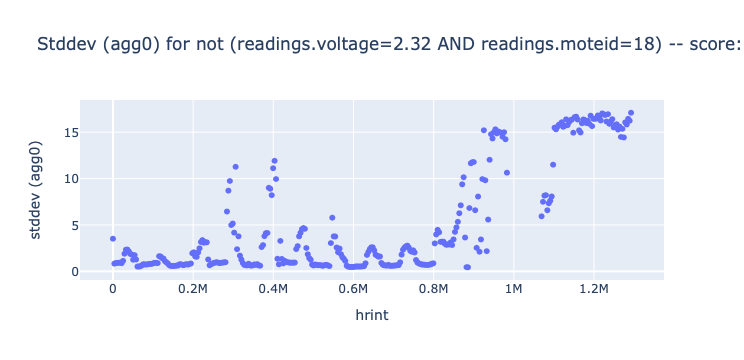

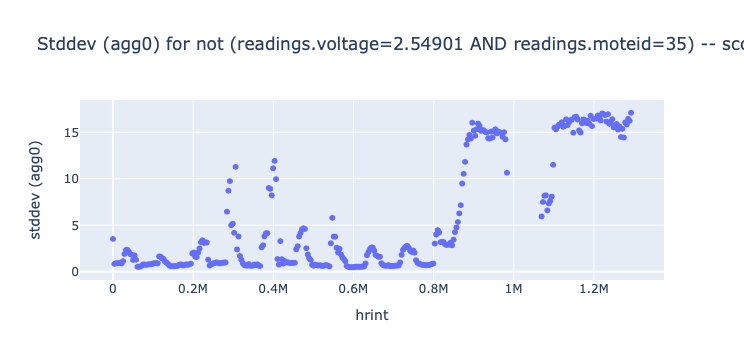

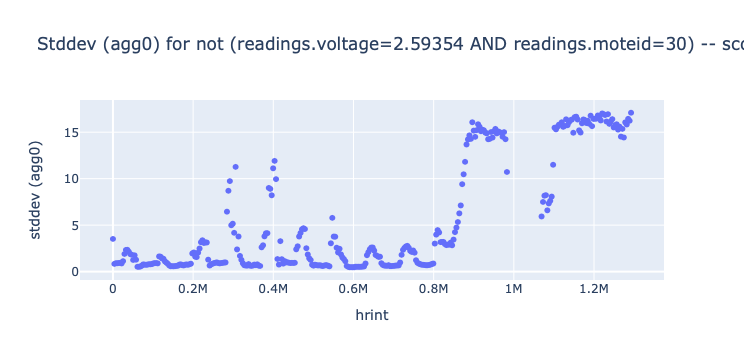

In [190]:
################################
# Step 8 replot
################################
def plot_stddev_for_predicates(select_clause, gb_clause, predicates):
    # Create a figure with one subplot per predicate
    figs = []
    for v in predicates:
        p = ' AND '.join(v['clauses'])
        filtered_df = con.execute(select_clause + f" where not ({p})" + gb_clause).df() 
        name = f"not ({p}) -- score: {v['score']}"
        if filtered_df.empty:
            print(f"{name}: No data matched.")
            continue
        
        # Here we plot stddev values for the subset - you can customize plot type
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=filtered_df['hrint'],
            y=filtered_df['agg0'],  # stddev values
            mode='markers',
            name=name
        ))
        fig.update_layout(title=f"Stddev (agg0) for {name} ", xaxis_title="hrint", yaxis_title="stddev (agg0)")
        figs.append(fig)
    
    # Display all figures sequentially
    for fig in figs:
        display(fig)

# Example usage
select_clause =  "SELECT hrint, stddev(temp) as agg0, avg(temp) as agg1  FROM readings AS readings "
gb_clause =  " GROUP BY hrint"

plot_stddev_for_predicates(select_clause, gb_clause, results)
